# Introduction

The data for this competition comes from two devices: a source device (with errors and missing data) and a benchmark device (that takes much more accurate readinds we'd like to match). 

In this starter notebook, we'll load in the source data and the targets, come up with the most basic way we can think of to implement a solution, make a submission and then look at places we could start to improve.

# Loading and viewing the data

The first step is to load the data. The test data takes the form of sequences with ~120 seconds worth of readings from the source device. The training data looks similar but we're also given a corresponding target for each sequence. 

Let's get a list of sequences and a list of the coresponding targets, and set up some convenience functions to view them and start to get a feel for the data:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import glob, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.multioutput import MultiOutputRegressor
from xgboost.sklearn import XGBRegressor
import traces # For interpolation - pip install traces

In [3]:
# Get the train input sequences
sequences = sorted(glob.glob('train_sequences/*.csv'))
sequences[:3]

['train_sequences\\track16_seq0_source.csv',
 'train_sequences\\track16_seq10_source.csv',
 'train_sequences\\track16_seq11_source.csv']

In [4]:
# And their corresponding outputs
targets = [s.replace('sequence', 'target').replace('source', 'target') for s in sequences]
targets[:3]

['train_targets\\track16_seq0_target.csv',
 'train_targets\\track16_seq10_target.csv',
 'train_targets\\track16_seq11_target.csv']

In [5]:
# Load a sequence and return source and target dataframes
def load_seq(i):
    source = pd.read_csv(sequences[i])
    target = pd.read_csv(targets[i])
    return source, target

In [6]:
# Example:
source, target = load_seq(0)
source.head(3)

,Time,Latitude,Longitude,Movement_Type,Accuracy
0,0.000,-0.001460,0.000430,2,16.464001
1,1.000,-0.001431,0.000429,2,16.521999
2,2.034,-0.001336,0.000439,2,16.827999


Source has some extra data - Movement Type and GPS accuracy.

In [7]:
# And the target
target.head(3)

,Time,Latitude,Longitude
0,0,-0.001519,0.000400
1,1,-0.001483,0.000405
2,2,-0.001444,0.000407


Just looking at the data doesn't tell us much - let's plot the two together and see what this looks like.

In [8]:
# View a sequence
def plot_seq(source, target):
    min_x, max_x, min_y, max_y = target.Longitude.min(), target.Longitude.max(), target.Latitude.min(), target.Latitude.max()
    ax = target.plot(x='Longitude', y='Latitude', c='red', label='Benchmark track',
                ylim=(min_y-0.0004, max_y+0.0004), xlim=(min_x-0.0004, max_x+0.0004)) # Extra margin
    source.plot(x='Longitude', y='Latitude', c='green', kind='scatter', label='Source (input)', ax=ax, alpha=0.3)
    
    target.plot(x='Longitude', y='Latitude', c='blue', label='Target', ax=ax, kind='scatter', alpha=0.3)
    return ax

101


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

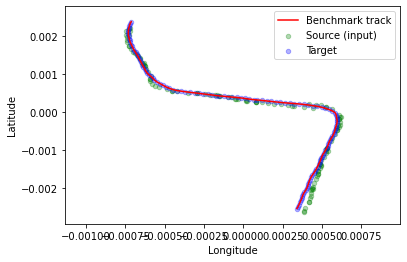

In [9]:
# Load and view a random example
n = random.randint(0, len(sequences))
print(n)
source, target = load_seq(n)
plot_seq(source, target)

# Understanding the problem

So, what makes this hard? Run the cell above a few times and you'll see that we have two main challenges:
- There are gaps in the source data - places where the GPS location is repeated again and again with no updates. This corresponds to a loss of GPS signal in the device
- There accuracy isn't that great even when locations are reported. The source device tries its best but the GPS isn't very accurate compared to the benchmark device. You can actually inspect the estimated GPS accuracy reported by the source device by looking at the Accuracy column.

When we drop rows with duplicate locations, we can see how much data is missing. Let's look at a specific example which we'll then use to come up with our first solution:

In [10]:
source, target = load_seq(247)
source.shape, source.drop_duplicates(subset='Latitude').shape

((120, 5), (67, 5))

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

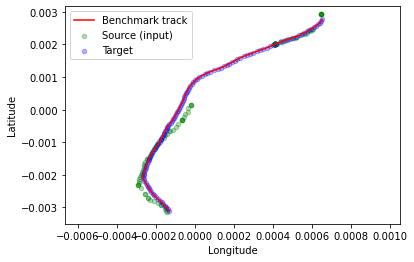

In [11]:
plot_seq(source, target)

Notice the gap in the middle... We onl have 67 readings once we remove duplicates! Let's try to fix that by filling in some sensible values.

# A Minimal Solution

Before we even look at learning-based solutions, let's try some simple interpolation. If we ignore repeat locations and instead try to fill in the data with linear interpolation based on the points we do have, won't that get us pretty close? 

Here I'm using the traces library to treat the Latitude and Longitude columns as two independant timeseries, which we can re-sample to the nice, neat 1-second interval we need to match the target:

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

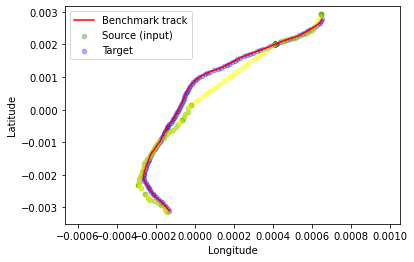

In [12]:
def smooth(source):
    
    # Create a dataframe to store our predictions
    preds = pd.DataFrame({
        'Time':range(120)
    })
    original_sub = source.copy()
    
    # Drop duplicates from the source (places where GPS is lost)
    source = source.drop_duplicates(subset='Latitude')
    
    # Create traces timeseries for both Latitude and Longitude
    lat_ts = traces.TimeSeries([s for s in source[['Time', 'Latitude']].values])
    lon_ts = traces.TimeSeries([s for s in source[['Time', 'Longitude']].values])
    
    # Resample with linear interpolation and store results
    preds['Latitude'] = [x[1] for x in lat_ts.sample(sampling_period=1,interpolate='linear', start=0, end=119)]
    preds['Longitude'] = [x[1] for x in lon_ts.sample(sampling_period=1,interpolate='linear', start=0, end=119)]
    
    if 'Accuracy' in original_sub.columns: # In case we want to use this smooth function on benchmark data
        preds['Accuracy'] = original_sub['Accuracy']
        preds['Movement_Type'] = original_sub['Movement_Type']
    
    # Return the predictions
    return preds

# Plot the result when we apply this to our sequence
ax = plot_seq(source, target)
preds = smooth(source)

preds.plot(x='Longitude', y='Latitude', kind='scatter', c='yellow', ax=ax, alpha=0.3)

We've filled in the gap pretty well. And we didn't need to do any modelling! Let's use this to set up our testing and submission strategy.

# Metrics and Submission

The competition uses RMSE and requires predictions in a specific format. Let's first replicate the scoring and then make a submission file to see how well we do on the leaderboard.

In [13]:
# Scoring a our preds vs the target for this sequence
mean_squared_error(target[['Latitude', 'Longitude']], preds[['Latitude', 'Longitude']], squared=False)

6.3822264116194e-05

In [14]:
# Making predictions for all sequences and combining all targets:
all_targets = pd.concat([load_seq(i)[1] for i in range(len(sequences))])
all_preds = pd.concat([smooth(load_seq(i)[0]) for i in range(len(sequences))])

# Scoring function
def score(targets, preds):
    return np.sqrt(mean_squared_error(targets[['Latitude', 'Longitude']], preds[['Latitude', 'Longitude']]))

# Show our score
score(all_targets, all_preds)

0.0003553909051712651

There are many different ways you could implement the above code, but this is good enough to give us a score. Next we need to turn our predictions into the right format. Let's load in the sample submission and get to work:

In [15]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,Row_ID,Prediction
0,SEQ_AKvyOXIS X time0 X Latitude,0
1,SEQ_AKvyOXIS X time0 X Longitude,0
2,SEQ_AKvyOXIS X time1 X Latitude,0
3,SEQ_AKvyOXIS X time1 X Longitude,0
4,SEQ_AKvyOXIS X time10 X Latitude,0


We need one row for each sequence for each time for each column (lat and lon). For conveneince, let's add some extra columns to make life easier:

In [16]:
# Adding extra columns to ss
ss['Seq_ID'] = ss['Row_ID'].apply(lambda s: s.split(' X ')[0])
ss['Time'] = ss['Row_ID'].apply(lambda s: s.split(' X ')[1][4:])
ss['Col'] = ss['Row_ID'].apply(lambda s: s.split(' X ')[2])
ss.sample(3)

,Row_ID,Prediction,Seq_ID,Time,Col
12927,SEQ_GkNlWSMM X time84 X Longitude,0,SEQ_GkNlWSMM,84,Longitude
103376,SEQ_yjkcLhdT X time70 X Latitude,0,SEQ_yjkcLhdT,70,Latitude
3884,SEQ_CBkeCwRy X time118 X Latitude,0,SEQ_CBkeCwRy,118,Latitude


Now we can iterate through the test sequences, making predictions for each one with our 'smooth' function and writing the data to the ss dataframe. 

If you're careful with the ordering you can avoid those time-consuming `.loc` lines and write the predictions in one go, but this way is nice and explicit and it doesn't take too long.

In [17]:
# Ordering by Time to keep row order consistent <<<<< Fix for initial error
ss['Time'] = ss['Time'].astype(int)
ss = ss.sort_values(by='Time')

seq_ids = ss['Seq_ID'].unique() # The sequences we need to make predictions on
print('Seq IDs:', seq_ids[:3], '...') # Print examples

# Going through the sequences one by one
for seq_id in seq_ids:
    
    # Load the source data
    source = pd.read_csv(f'test_sequences/{seq_id}_source.csv')
    
    # Make predictions
    preds = smooth(source) 
    
    # Write the predictions to the right place in ss
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Latitude'), 'Prediction'] = preds['Latitude'].values
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Longitude'), 'Prediction'] = preds['Longitude'].values
    
# Check that we now have data in our 'Prediction' column
ss.sample(5)

Seq IDs: ['SEQ_AKvyOXIS' 'SEQ_mrGTzHGM' 'SEQ_tICBnHQa'] ...


,Row_ID,Prediction,Seq_ID,Time,Col
36209,SEQ_SZHvGHzI X time85 X Longitude,0.000092,SEQ_SZHvGHzI,85,Longitude
45056,SEQ_XjDlDmER X time70 X Latitude,0.000577,SEQ_XjDlDmER,70,Latitude
27181,SEQ_NwOnTjXn X time18 X Longitude,0.000148,SEQ_NwOnTjXn,18,Longitude
74288,SEQ_mjVkPNQu X time49 X Latitude,0.000206,SEQ_mjVkPNQu,49,Latitude
82377,SEQ_ptJpSllj X time16 X Longitude,0.000701,SEQ_ptJpSllj,16,Longitude


In [18]:
# Save our predictions 
ss[['Row_ID', 'Prediction']].to_csv('submission1.csv', index=False)

This submission file can be uploaded on Zindi for a score. The test set comes from a different set of tracks, so your scores might be different on the leaderboard when compared to local scoring, but the local score let's you pick your best strategies before using a submission on Zindi. 

Now that we have a first solution in, let's look at the data more closely and brainstorm some ways of improving our performance.

# Applying machine learning

In this section, we'll apply machine learning instead of simple interpolation and see the difference. Fistly, we'll load all data in matrix format. Secondly, we will split the data into training and validation. Thirdly, we'll train a model on the training data and check the error on the validation data. Finally, we'll maka a submission using our model.

## Read all data

Each track (for source and target) has 120 timestamp and each timestamp has 4 attributes (if we ignore time). So, we'll create a feature vector for each track with 120 X 4 = 480 features. Our goal will predicting the target's 240 value (120 langitude and 120 latitude).

In [19]:
all_source_data = []
all_target_data = []
key_features = ['Latitude', 'Longitude', 'Movement_Type', 'Accuracy']

for i in range(len(sequences)):
    print(i)
    source, target = load_seq(i)
    if source.shape[0] != 120:
        print(i)
        continue

    source = smooth(source)
    if sum(source.isnull().sum()) !=0:
        continue
    print('Data shape before vectorization: ', source[key_features].shape, target[key_features[:2]].shape)
    source_feat_flatten = source[key_features].values.flatten().reshape(1, -1)
    target_flatten = target[key_features[:2]].values.flatten().reshape(1, -1)
    print('Data shape after vectorization: ', source_feat_flatten.shape, target_flatten.shape)
    all_source_data.append(source_feat_flatten)
    all_target_data.append(target_flatten)

all_source_data = np.concatenate(all_source_data, 0)
all_target_data = np.concatenate(all_target_data, 0)
print('Final all data shape', all_source_data.shape, all_target_data.shape)

0
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
1
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
2
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
3
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
4
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
5
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
6
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
7
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
8
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
9
Data shape before vectorization:  (120, 4) (120, 2)
D

## Data splitting

We want to split the data into training and validation as we have limited number of submissions in the hackathon and we need to have a way of evaluating our model before submission. Having a held out validation set will help achieve that. The most important aspect is to split the data so that validation is completely unseen to the model in order to have a proper evaluation. Therefore, we will split the data by the original track number so that no track has no data in both training and validation.

In [20]:
source_files = glob.glob('train_sequences/*source.csv')
track_numbers = [int(s.split('track')[-1].split('_')[0]) for s in source_files]

gss = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
#split the data so that a track number doesn't occur at training and validation in the sametime
for train_index, val_index in gss.split(all_source_data, all_target_data, track_numbers):
    train_source_data, val_source_data = all_source_data[train_index], all_source_data[val_index]
    train_target_data, val_target_data = all_target_data[train_index], all_target_data[val_index]
    print('Training data size: ', train_source_data.shape, train_target_data.shape)
    print('Validation data size: ', val_source_data.shape, val_target_data.shape)
    break

Training data size:  (389, 480) (389, 240)
Validation data size:  (164, 480) (164, 240)


## Train and evaluate a machine learning model
Now we will train a machine learning called gradient boosting machine which is a variant of decision tree model. Since we need to predict 240 numerical value per sample (track), we need to train a multi-output regression model.

In [22]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_jobs=-1)
model = MultiOutputRegressor(random_forest)
model.fit(train_source_data, train_target_data)

val_preds = model.predict(val_source_data)
val_error = np.sqrt(mean_squared_error(val_target_data, val_preds))
print('validation error: ', val_error)


validation error:  0.0001386334308901459


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=200,learning_rate=0.1)
gbm = MultiOutputRegressor(gbm,n_jobs=-1)
gbm.fit(train_source_data, train_target_data)

val_predsgbm = gbm.predict(val_source_data)
val_error = np.sqrt(mean_squared_error(val_target_data, val_preds))
print('validation error: ', val_error)

validation error:  0.0001386334308901459


In [27]:
from catboost import CatBoostRegressor

cbr= CatBoostRegressor(n_estimators=200,learning_rate=0.1)
cbr = MultiOutputRegressor(cbr,n_jobs=-1)
cbr.fit(train_source_data, train_target_data)
val_predscbr = cbr.predict(val_source_data)
val_error = np.sqrt(mean_squared_error(val_target_data, val_preds))
print('validation error: ', val_error)

validation error:  0.0001386334308901459


In [32]:
from xgboost import XGBRegressor

#XGBoost Model
xgb = XGBRegressor(n_estimators= 200,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squaredlogerror',
 nthread= -1,
 scale_pos_weight=1
 ,learning_rate=0.1
 ,n_jobs =-1)
xgb = MultiOutputRegressor(xgb,n_jobs=-1)
xgb.fit(train_source_data, train_target_data)

val_predsxgb = xgb.predict(val_source_data)
val_error = np.sqrt(mean_squared_error(val_target_data, val_predsxgb))
print('validation error: ', val_error)

validation error:  0.0009898536417535153


In [34]:
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

model_lgbm = lgbm.LGBMRegressor()
model_lgbm = MultiOutputRegressor(model_lgbm)


model_lgbm.fit(
    train_source_data, 
    train_target_data)

val_predslgbm = model_lgbm.predict(val_source_data)
val_error = np.sqrt(mean_squared_error(val_target_data, val_predslgbm))
print('validation error: ', val_error)

validation error:  0.0001373137476754785


In [ ]:
#Simple Averaging/ 

#Y_pred=(rf_pred+abc_pred+gbm_pred+cbc_pred+xgb_pred+model_lgbm_pred)/6
#Y_pred=(rf_pred+abc_pred+gbm_pred+cbc_pred+xgb_pred+model_lgbm_pred)/6

#Y_pred=Y_pred.round(0)
#converting from float to integer
#Y_pred=Y_pred.astype(int)

We can see that our score with machine learning is better than just simple smoothing.

## Make a submission

In [35]:
# Ordering by Time to keep row order consistent <<<<< Fix for initial error
ss['Time'] = ss['Time'].astype(int)
ss = ss.sort_values(by='Time')

seq_ids = ss['Seq_ID'].unique() # The sequences we need to make predictions on
print('Seq IDs:', seq_ids[:3], '...') # Print examples

# Going through the sequences one by one
for seq_id in seq_ids:
    
    # Load the source data
    source = pd.read_csv(f'test_sequences/{seq_id}_source.csv')
    
    # Make predictions
    source = smooth(source) 
    source_feat_flatten = source[key_features].values.flatten().reshape(1, -1)
    preds = model_lgbm.predict(source_feat_flatten)
    preds = preds.reshape(source.shape[0], 2)
    
    
    # Write the predictions to the right place in ss
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Latitude'), 'Prediction'] = preds[:,0]
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Longitude'), 'Prediction'] = preds[:,1]
    
# Check that we now have data in our 'Prediction' column
ss.sample(5)

Seq IDs: ['SEQ_AKvyOXIS' 'SEQ_pHezdhdu' 'SEQ_amlGBtdG'] ...


,Row_ID,Prediction,Seq_ID,Time,Col
81434,SEQ_pZWenMHk X time24 X Latitude,0.000430,SEQ_pZWenMHk,24,Latitude
15803,SEQ_HYMkYVHy X time82 X Longitude,0.000023,SEQ_HYMkYVHy,82,Longitude
96597,SEQ_vvuPPfoX X time43 X Longitude,-0.000768,SEQ_vvuPPfoX,43,Longitude
47311,SEQ_YqHeRcQW X time111 X Longitude,0.000485,SEQ_YqHeRcQW,111,Longitude
29470,SEQ_OoJtQRyd X time77 X Latitude,0.000139,SEQ_OoJtQRyd,77,Latitude


In [36]:
# Save our predictions 
ss[['Row_ID', 'Prediction']].to_csv('submission2.csv', index=False)